In [20]:
import numpy as np
import pandas as pd
import scipy.io as sio
from utils import get_palm_mask_484, get_true_indices, sample_to_events, get_filename_from_params, load_spike_data, plot_membrane_one_per_class
import torch
from models import create_cv_folds
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
import numpy as np
from snntorch import functional as SF
from matplotlib import pyplot as plt
from models import cv_train, FC_SNN_Syn
import snntorch.spikegen as spikegen

MAT_PATH = "smarthand_dataset.mat"
RANK_CSV = "res95_ranked_taxels.csv"   # produced by your PCA+Pearson script
SAMPLING_FREQUENCY = 100.0  # 100 frames/sec = 100 Hz
FRAME_DURATION_MS = 1000.0 / SAMPLING_FREQUENCY  # 10 ms per frame
NUM_FRAMES = 1200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [24]:
fixed_params = {"topn": None, "threshold": 0.01, "num_frames": 25, "session_id": [0, 1], "flatten_channels": True, "down_spike": -1.0, "encoding": "raw"}

filepath = get_filename_from_params(fixed_params, "preprocessed_data")

spike_tensors, y_tensors, _ = load_spike_data(filepath)

Loaded data from preprocessed_data\spike_data_topn_None_num_frames_25_threshold_0.01_flatten_channels_True_down_spike_-1.0_encoding_raw_session_id_0_1.pkl with params: {'topn': None, 'num_frames': 25, 'threshold': 0.01, 'session_id': [0, 1], 'flatten_channels': True, 'down_spike': -1.0, 'encoding': 'raw'}


In [25]:
spike_array = np.stack(spike_tensors, axis=0).astype(np.float32)   # (S, 25, N)
y_array     = np.array(y_tensors, dtype=np.int64)

print("spike_array.shape :", spike_array.shape)   # e.g. (B, 25, N_taxels)
print("y_array.shape     :", y_array.shape)       # (B,)

spike_array.shape : (1632, 25, 484)
y_array.shape     : (1632,)


In [29]:
spike_array[0][1]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 0.

In [26]:
(cv_train_data_folds, cv_train_labels_folds,
 cv_test_data_folds,  cv_test_labels_folds,
 val_data, val_labels, _, _) = create_cv_folds(
        spike_tensors   = spike_array,
        y_tensors       = y_array,
        num_folds       = 8,
        num_sessions    = 2,
        num_classes     = 17,
        random_state    = 42
)

Fold 1: CV Train samples = 1309, CV Test samples = 187
  - CV Train class distribution: [77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77]
  - CV Test class distribution: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11]
Fold 2: CV Train samples = 1309, CV Test samples = 187
  - CV Train class distribution: [77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77]
  - CV Test class distribution: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11]
Fold 3: CV Train samples = 1309, CV Test samples = 187
  - CV Train class distribution: [77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77]
  - CV Test class distribution: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11]
Fold 4: CV Train samples = 1309, CV Test samples = 187
  - CV Train class distribution: [77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77 77]
  - CV Test class distribution: [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11]
Fold 5: CV Train samples = 1309, CV Test samples = 187
  - CV Train class distribution: [77 77 7

In [31]:
results = cv_train(
        cv_train_data_folds   = cv_train_data_folds,
        cv_train_labels_folds = cv_train_labels_folds,
        cv_test_data_folds    = cv_test_data_folds,
        cv_test_labels_folds  = cv_test_labels_folds,
        model_class           = FC_SNN_Syn,   # or any of your models
        num_folds             = 5,
        num_epochs            = 10,
        batch_size            = 64,
        num_inputs            = 484,
        num_outputs           = 17,
        loss_fn               = 'combined',
        return_weights        = False,
        return_membrane       = True,
        alpha                 = 0.7,
        beta                  = 0.7,
        device                = device,
        verbose               = True,
        lr                    = 0.001
)


Starting Fold 1/5 for model FC_SNN_Syn
Fold 1, Epoch 1 - Avg Train Loss: 3.1880, Avg Train Accuracy: 6.04%
Fold 1, Epoch 1 - Avg Test Loss: 2.8798, Avg Test Accuracy: 5.88%
Fold 1, Epoch 2 - Avg Train Loss: 2.8594, Avg Train Accuracy: 5.27%
Fold 1, Epoch 2 - Avg Test Loss: 2.8558, Avg Test Accuracy: 5.88%
Fold 1, Epoch 3 - Avg Train Loss: 2.8474, Avg Train Accuracy: 5.58%
Fold 1, Epoch 3 - Avg Test Loss: 2.8453, Avg Test Accuracy: 5.88%
Fold 1, Epoch 4 - Avg Train Loss: 2.8457, Avg Train Accuracy: 6.57%
Fold 1, Epoch 4 - Avg Test Loss: 2.8504, Avg Test Accuracy: 5.88%
Fold 1, Epoch 5 - Avg Train Loss: 2.8519, Avg Train Accuracy: 6.80%
Fold 1, Epoch 5 - Avg Test Loss: 2.8523, Avg Test Accuracy: 5.88%
Fold 1, Epoch 6 - Avg Train Loss: 2.8550, Avg Train Accuracy: 6.11%
Fold 1, Epoch 6 - Avg Test Loss: 2.8515, Avg Test Accuracy: 5.88%
Fold 1, Epoch 7 - Avg Train Loss: 2.8512, Avg Train Accuracy: 5.58%
Fold 1, Epoch 7 - Avg Test Loss: 2.8452, Avg Test Accuracy: 5.88%
Fold 1, Epoch 8 - Avg 

c:\Users\marti\stag\utils.py:600: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


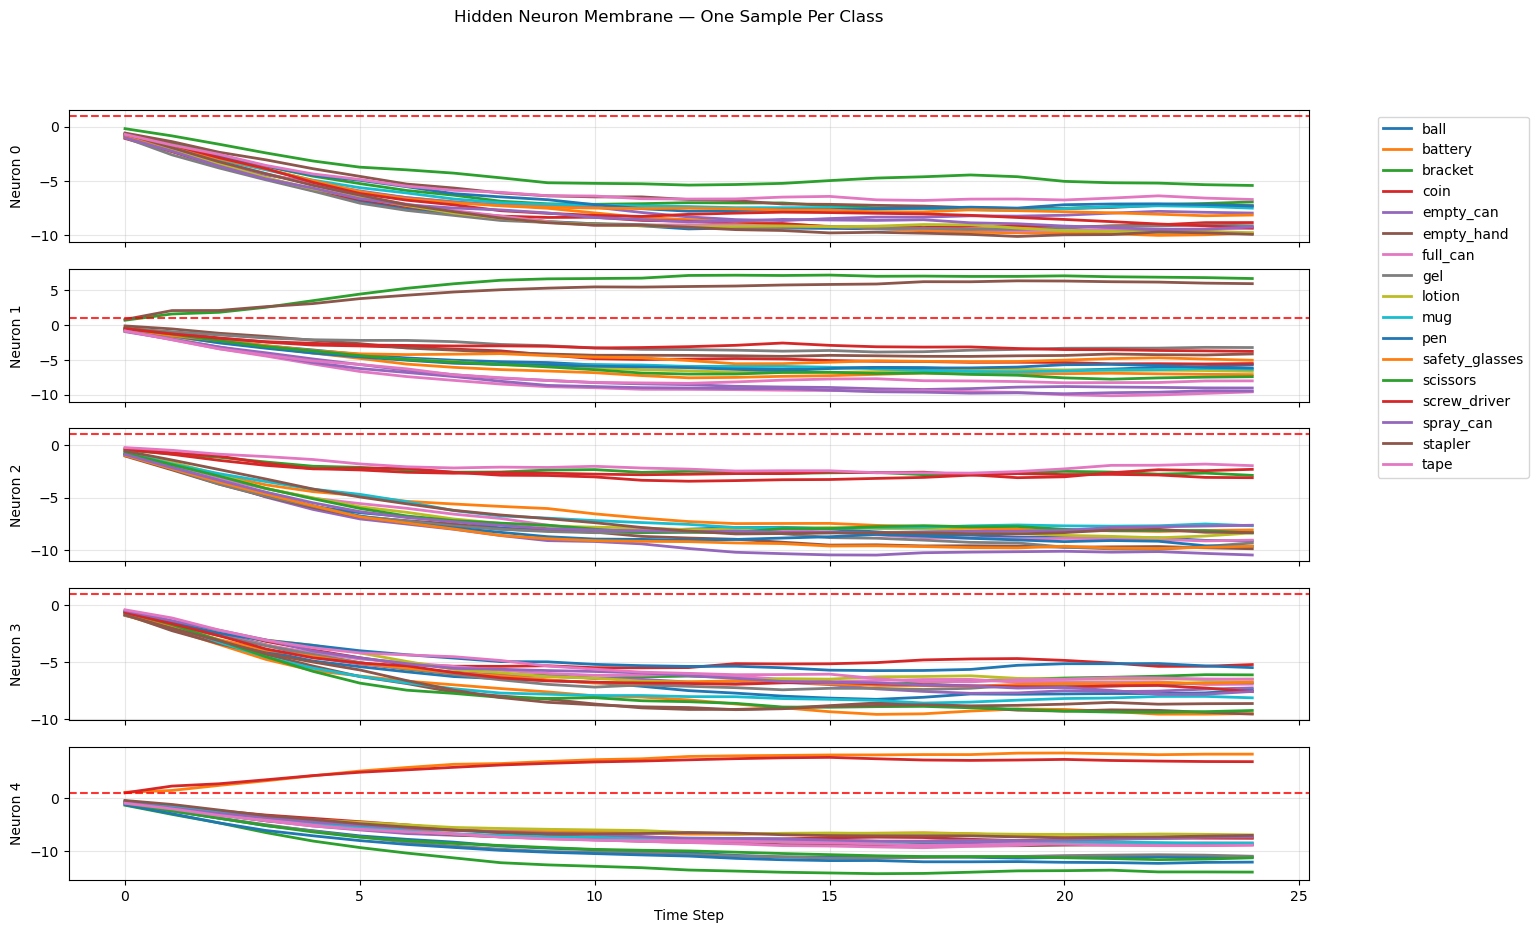

In [32]:
class_names = ['ball', 'battery', 'bracket', 'coin', 'empty_can', 'empty_hand', 'full_can',
               'gel', 'lotion', 'mug', 'pen', 'safety_glasses', 'scissors', 'screw_driver',
               'spray_can', 'stapler', 'tape']

plot_membrane_one_per_class(results, num_neurons=5)


In [33]:
def plot_membrane_with_spikes(results, sample_idx=0, neuron=0):
    mem = results['hidden_membrane'][sample_idx, :, neuron]
    true_class = results['hidden_membrane_labels'][sample_idx]
    
    plt.figure(figsize=(10, 4))
    plt.plot(mem, label='Membrane', color='blue')
    spikes = np.where(mem >= 1.0)[0]
    plt.scatter(spikes, mem[spikes], color='red', s=50, label='Spike')
    plt.axhline(1.0, color='red', linestyle='--', alpha=0.7)
    plt.title(f"Class {true_class} — Neuron {neuron} — {len(spikes)} spikes")
    plt.xlabel("Time Step")
    plt.ylabel("Membrane Potential")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

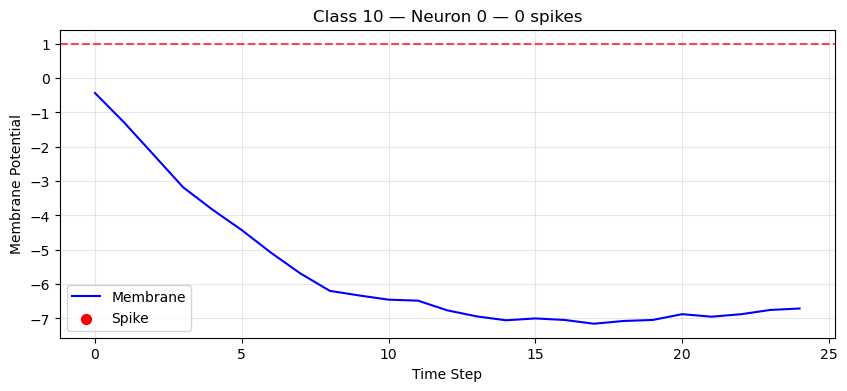

In [35]:
plot_membrane_with_spikes(results, sample_idx=2, neuron=0)